**Import Libraries**

In [1]:

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


**Load EuroSAT Dataset**

In [3]:
from datasets import load_dataset

ds = load_dataset("blanchon/EuroSAT_RGB")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5400 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5400 [00:00<?, ? examples/s]

**Inspect the Dataset Structure**

In [6]:
ds


DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 16200
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
})

**Convert Hugging Face Dataset → TensorFlow**

Get class names

In [7]:
class_names = ds["train"].features["label"].names
num_classes = len(class_names)

print(class_names)
print("Classes:", num_classes)


['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial Buildings', 'Pasture', 'Permanent Crop', 'Residential Buildings', 'River', 'SeaLake']
Classes: 10


**Convert to TensorFlow Dataset**

explicitly convert PIL → NumPy → Tensor

**Note:**  
Hugging Face datasets store images as PIL.Image

TensorFlow cannot automatically convert PIL objects to tensors

In [12]:
IMG_SIZE = 64

def preprocess(example):
    image = np.array(example["image"])                 # PIL → NumPy
    image = tf.convert_to_tensor(image, tf.float32)    # NumPy → Tensor
    image = image / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    return {
        "image": image,
        "label": example["label"]
    }


In [13]:
BATCH_SIZE = 32

tf_train = ds["train"].with_transform(preprocess).to_tf_dataset(
    columns=["image"],
    label_cols="label",
    shuffle=True,
    batch_size=BATCH_SIZE
)

tf_val = ds["validation"].with_transform(preprocess).to_tf_dataset(
    columns=["image"],
    label_cols="label",
    batch_size=BATCH_SIZE
)

tf_test = ds["test"].with_transform(preprocess).to_tf_dataset(
    columns=["image"],
    label_cols="label",
    batch_size=BATCH_SIZE
)


**Sanity Check**

In [14]:
for images, labels in tf_train.take(1):
    print(images.shape, images.dtype)
    print(labels.shape)


(32, 64, 64, 3) <dtype: 'float32'>
(32,)


**Architecture Overview**

**1. Input Layer**

Implicitly defined by input_shape=**(64,64,3)**

Accepts images of size 64×64 pixels with 3 color channels (**RGB**)

**Total input:** 64×64×3 = 12,288 values

**2. Convolutional Block 1**


> Conv2D(32, 3, activation="relu")


**32 filters:** Learns 32 different feature detectors

**3×3 kernel size:** Each filter scans 3×3 pixel regions

**ReLU activation:** Introduces non-linearity (Rectified Linear Unit)

**Output shape:** After convolution, size becomes 62×62×32



(64-3+1) = 62 (no padding specified)

> MaxPooling2D()



**Default 2×2 pooling:** Reduces spatial dimensions by half

Takes maximum value from each 2×2 region

**Output shape:** 31×31×32 (62/2 = 31)

**3. Convolutional Block 2**


> Conv2D(64, 3, activation="relu")

**64 filters:** Learns more complex features

**Output shape:** 29×29×64 (31-3+1 = 29)


> MaxPooling2D()

**Output shape:** 14×14×64 (29/2 = 14.5 → rounds down to 14)

**4. Convolutional Block 3**


> Conv2D(128, 3, activation="relu")



**128 filters:** Learns high-level, abstract features

**Output shape:** 12×12×128 (14-3+1 = 12)


> MaxPooling2D()



**Output shape:** 6×6×128 (12/2 = 6)

**5. Transition to Fully Connected Layers**


> Flatten()


Converts 3D feature maps (6×6×128) into 1D vector

**Output:** 6×6×128 = 4,608 neurons

**6. Dense (Fully Connected) Layers**


> Dense(128, activation="relu")



**128 neurons:** Learns combinations of features

**ReLU activation:** Non-linear transformation


> Dense(num_classes, activation="softmax")



**Output layer:** One neuron per class

**Softmax activation:** Converts outputs to probabilities (sums to 1)

**Build CNN Model**

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(64,64,3)),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

**Compile the model**

**1. Optimizer:**
> optimizer="adam"

**Adam** (Adaptive Moment Estimation) is the most popular optimizer for deep learning:


*   **Combines benefits:** Momentum + RMSprop
*   **Adaptive learning rates:** Different rates for each parameter
*   **Automatic tuning:** Adjusts learning rate during training


**Default parameters:**


> Learning rate: 0.001

> Beta1: 0.9 (for momentum)

> Beta2: 0.999 (for RMSprop)

> Epsilon: 1e-7 (numerical stability)



**Why Adam is preferred:**


*   Converges faster than SGD (Stochastic Gradient Descent)
*   Handles sparse gradients well
*   Less sensitive to learning rate choice
*   Good default choice for most problems

**2. Loss Function:**
> loss="sparse_categorical_crossentropy"

This is a **multi-class classification loss** with specific characteristics:

**When to use sparse_categorical_crossentropy:**
*  **Labels are integers:** Class indices (0, 1, 2, ...)

* **Example:** If you have 3 classes, labels = [0, 2, 1, 0, ...]

* **Output layer:** Must have softmax activation (outputs probabilities)

**3. Metrics:**
> metrics=["accuracy"]

**Accuracy** is the evaluation metric for monitoring:

**Formula:**
> (correct predictions) / (total predictions)

**Computed during:** Training and validation

**What you'll see in logs:**

> loss: Training loss (to minimize)

> accuracy: Training accuracy

> val_loss: Validation loss

> val_accuracy: Validation accuracy

**Other common metrics you could add:**
> metrics=["accuracy", "precision", "recall"]

In [18]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


**Train the model**

**1. Training Data:**
> tf_train
* This is your training dataset (likely a TensorFlow Dataset object)
* Should contain both features (images) and labels
* Batch size is defined when creating the dataset

**2. Validation Data:**
> validation_data=tf_val
* Separate dataset for evaluating during training

* Not used for training, only for monitoring generalization

* **Critical for:** Detecting overfitting, early stopping, hyperparameter tuning

* Should have same structure as training data

**3. Epochs:**
> epochs=15

**One epoch =** One complete pass through the entire training dataset

**15 epochs =** Model sees the training data 15 times

**Typical ranges:**

* Simple tasks: 10-30 epochs

* Complex tasks: 50-100+ epochs

* Early stopping often used to prevent overfitting

In [19]:
history = model.fit(
    tf_train,
    validation_data=tf_val,
    epochs=15
)

Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 93s 180ms/step - accuracy: 0.3913 - loss: 1.5679 - val_accuracy: 0.6406 - val_loss: 0.9635
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 84s 165ms/step - accuracy: 0.6834 - loss: 0.8701 - val_accuracy: 0.7496 - val_loss: 0.7085
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 90s 176ms/step - accuracy: 0.7410 - loss: 0.7101 - val_accuracy: 0.7593 - val_loss: 0.6740
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 91s 180ms/step - accuracy: 0.7724 - loss: 0.6211 - val_accuracy: 0.7630 - val_loss: 0.6701
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 133s 162ms/step - accuracy: 0.8002 - loss: 0.5501 - val_accuracy: 0.7315 - val_loss: 0.7779
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 141s 160ms/step - accuracy: 0.8247 - loss: 0.4925 - val_accuracy: 0.8135 - val_loss: 0.5204
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 84s 165ms/step - accuracy: 0.8611 - loss: 0.3866 - val_accuracy: 0.7972 - val_loss: 0.6113
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 84s 166ms/step - accuracy: 0.8606 - loss:

**What Happens During Training:**

**For Each Epoch:**

**1. Training Phase:**

* Model processes training data in batches

* Updates weights using backpropagation

* Computes loss and accuracy

**2. Validation Phase:**

* Model evaluates on validation data (no weight updates)

* Computes validation loss and accuracy

* Shows generalization performance



**Evaluation Phase:**

* No training occurs (weights aren't updated)

* Forward pass only through the model

* Computes metrics specified in model.compile()

* Returns loss value + metric values

**Evaluate**

In [20]:
test_loss, test_acc = model.evaluate(tf_test)
print(f"Test Accuracy: {test_acc:.4f}")


169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8636 - loss: 0.5130
Test Accuracy: 0.8470


**Sample Predictions (Visualization)**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


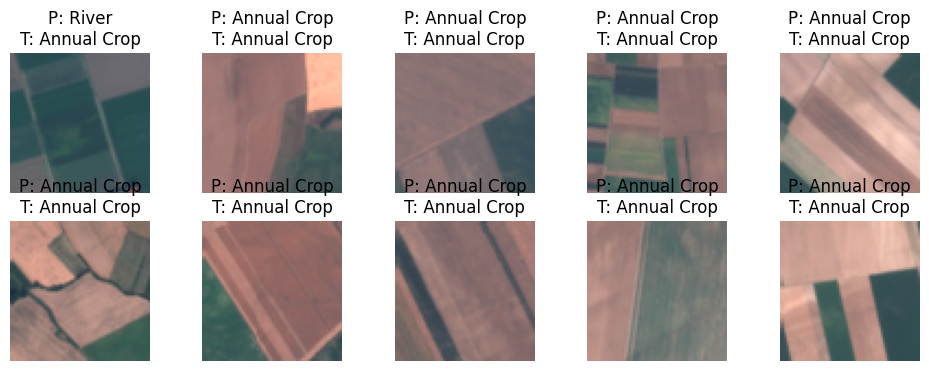

In [21]:
import numpy as np
import matplotlib.pyplot as plt

for images, labels in tf_test.take(1):
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    plt.figure(figsize=(12,4))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i])
        plt.title(f"P: {class_names[preds[i]]}\nT: {class_names[labels[i]]}")
        plt.axis("off")
    plt.show()


After training for 15 epochs, the model achieved a test accuracy of 0.8470. This indicates that the trained CNN is capable of classifying satellite images into their respective land-cover categories with a good level of accuracy on unseen data. While there's always room for further improvement (e.g., through more complex architectures, data augmentation, or hyperparameter tuning), this result serves as a solid foundation for further exploration in satellite image classification.